In [ ]:
import numpy as np
import pandas as pd
import random
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [ ]:
import torch.nn as nn
import torch.nn.utils
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

print(f'GPU available: {torch.cuda.is_available()}')

Mon Dec 13 05:29:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Data Preprocess

In [ ]:
#%% read the data (this is the way to read the input column as list of strings)
train = pd.read_csv("complaints_train.csv", converters={"input": lambda x: x.strip("[]").replace("'","").split(", ")})
test = pd.read_csv("complaints_test.csv", converters={"input": lambda x: x.strip("[]").replace("'","").split(", ")})
print(train.head(5))
print(test.head(5))

                                               input  label
0  [began, charg, addit, per, month, call, even, ...      6
1  [file, document, inaccurate, unknown, account,...      3
2  [request, document, bureau, file, contain, wet...      3
3  [account, longer, active, remov, credit, repor...      3
4  [due, job, loss, husband, unable, pay, credit,...      3
                                               input  label
0  [sent, letter, day, ago, request, incorrect, i...      3
1  [ny, social, secur, dob, herebi, make, ghostle...      4
2  [contract, longer, able, view, account, online...      4
3  [repeat, call, compani, say, tri, collect, deb...      4
4  [move, tri, change, internet, new, address, to...      4


In [ ]:
#%% build word count
sentences_train = train["input"].tolist()
sentences_test = test["input"].tolist()
labels_train = train["label"].tolist()
labels_test = test["label"].tolist()

In [ ]:
def shorten_word_list(sentences, max_len):
    shortened_sentences = []
    for sentence in sentences:
        if max_len >= len(sentence):
            shortened_sentences.append(sentence)
        else:
            shortened_sentences.append(sentence[:max_len])
    return shortened_sentences

In [ ]:
from collections import Counter
wordCounts = Counter([w for l in sentences_train for w in l])
print(wordCounts)
print(len(wordCounts))
singletons = set([w for (w,c) in wordCounts.items() if c == 1])
print(singletons)
print(len(singletons))

def find_max_min_avg_list(lst):
    lst_len = [len(i) for i in lst]
    print(max(lst_len))
    print(min(lst_len))
    print(sum(lst_len)/len(lst_len))

print(find_max_min_avg_list(sentences_train))

Counter({'account': 264717, 'credit': 261727, 'report': 261158, 'inform': 125795, 'payment': 100916, 'call': 88215, 'debt': 75123, 'day': 73036, 'time': 71553, 'compani': 67551, 'receiv': 65986, 'consum': 63910, 'bank': 63686, 'letter': 62864, 'request': 61948, 'would': 61069, 'loan': 58992, 'card': 56850, 'sent': 56450, 'collect': 56150, 'state': 53497, 'file': 52477, 'also': 48679, 'dispute': 48383, 'never': 47133, 'told': 46650, 'get': 46649, 'contact': 45185, 'bureau': 44683, 'number': 44256, 'date': 43812, 'ask': 42068, 'back': 40784, 'due': 39614, 'please': 38473, 'month': 37525, 'pay': 37108, 'ident': 37106, 'document': 36936, 'one': 36904, 'agenc': 36298, 'amount': 35928, 'close': 35847, 'balance': 35552, 'need': 35439, 'use': 35266, 'check': 35239, 'item': 34982, 'inquiri': 34601, 'money': 34174, 'still': 33650, 'open': 33418, 'paid': 32932, 'theft': 32878, 'violat': 32846, 'made': 32786, 'person': 32418, 'name': 31871, 'late': 31871, 'email': 31847, 'remov': 31779, 'said': 31

In [ ]:
sentences_train = shorten_word_list(sentences_train, max_len = 300)
print(find_max_min_avg_list(sentences_train))

300
1
73.96948751567666
None


In [ ]:
#%% map word to index
word2i = {w:i+2 for i,w in enumerate(set([w for l in sentences_train for w in l]))}
i2word = {i:w for w,i in word2i.items()}

#When training, randomly replace singletons with UNK tokens sometimes to simulate situation at test time.
def getDictionaryRandomUnk(w, dictionary, train = False):
  if train and (w in singletons and random.random() > 0.5):
    return 1
  else:
    return dictionary.get(w, 1)

#Map a list of sentences from words to indices.
def sentences2indices(words, dictionary, train=False):
  return [[getDictionaryRandomUnk(w,dictionary, train=train) for w in l] for l in words]

# Helper Function for prepare input and read GloVe

In [ ]:
def prepare_input(X_list): # input: list
    X_padded = torch.nn.utils.rnn.pad_sequence([torch.as_tensor(l) for l in X_list], batch_first=True).type(torch.LongTensor)
    X_mask   = torch.nn.utils.rnn.pad_sequence([torch.as_tensor([1.0] * len(l)) for l in X_list], batch_first=True).type(torch.FloatTensor)
    return (X_padded, X_mask)

def prepare_label(Y_list): # input: list
    label = torch.from_numpy(np.array((Y_list)))
    return torch.autograd.Variable(label).long()

In [ ]:
def read_glove(glove_fn):
    GloVe = {}
    for line in open(glove_fn, encoding = "utf-8").readlines():
        fields = line.strip().split(" ")
        word = fields[0]
        GloVe[word] = [float(x) for x in fields[1:]]
    return GloVe

def shuffle_sentences(sentences, tags):
    shuffled_sentences = []
    shuffled_tags      = []
    indices = list(range(len(sentences)))
    random.shuffle(indices)
    for i in indices:
        shuffled_sentences.append(sentences[i])
        shuffled_tags.append(tags[i])
    return (shuffled_sentences, shuffled_tags)

In [ ]:
## Read in 300 dimension GloVe

# !wget http://nlp.stanford.edu/data/glove.6B.zip 
# !unzip -q glove.6B.zip 
# glove_fn = "glove.6B.300d.txt"
# GloVe300 = read_glove(glove_fn)

In [ ]:
## Read in 50 dimension GloVe

glove_fn = "glove.6B.50d.txt"
GloVe50 = read_glove(glove_fn)

# Helper function for preprocess GloVe

In [ ]:
def glove_matrix(word2i, GloVe, dim) -> np.ndarray:

    """
    Returns an embedding matrix (lookup table) of word vectors given a vocabularly.
    Args:
        vocab: Vocabularly to build matrix for. Can either be an instance of Vocab() or
            a list. Words that have no embedding are initialised randomly.
    """

    matrix_len = max(word2i.values())+2
    vocab = word2i.keys()
    weights_matrix = np.zeros((matrix_len, dim))
    for i, word in enumerate(vocab):
        try:
            weights_matrix[i] = GloVe[word]
        except KeyError:
            weights_matrix[i] = np.random.uniform(-0.25, 0.25, size=(dim,))
    return weights_matrix

In [ ]:
weights_matrix = glove_matrix(word2i, GloVe50, 50)

# Helper function for Model

In [ ]:
# @torch.jit.script
# @torch.no_grad()
def fused_calc(m,h,z):
    m = m.cpu().detach().numpy()
    h = h.cpu().detach().numpy()
    z = z.cpu().detach().numpy()
    a = np.multiply((1-z), m)
    b = np.multiply(h, z)
    c = np.add(a, b)
    return  torch.from_numpy(c).to("cuda:0") #torch.from_numpy(c)

In [ ]:
def add_helper(a,b):
    # a = a.cpu().detach().numpy()
    # b = b.cpu().detach().numpy()
    c = a + b
    return c
    # return  torch.from_numpy(c).to("cuda:0")

# Neural Semantic Encoders Model

In [ ]:
class NSE(nn.Module):

    """
    Neural Semantic Encoder
    Reference: `Munkhdalai and Yu (2017). Neural Semantic Encoders. <https://www.aclweb.org/anthology/E17-1038/>`_
    Args:
        input_size: Input size, for most cases size of vocabularly.
        num_class: Number of classes.
        n_units: Dimension of embedding and LSTM layers.
        mlp_dim: Dimension of hidden layer in classification head.
        embed_mat: Pre-trained word-embeddings.
        dropout: Dropout applied to classification head
        freeze_embed: Freeze embedding weights during training.
    """

    def __init__(
        self,
        input_size: int,
        num_class: int = 7,
        n_units: int = 50,
        mlp_dim: int = 30,
        embed_mat = None,
        dropout: float = 0.5,
        freeze_embed: bool = False,
    ):
        super().__init__()

        self.n_units = n_units

        self.embedding = nn.Embedding(input_size, n_units, padding_idx=0)
        if embed_mat is not None:
            self.embedding = self.embedding.from_pretrained(
                torch.from_numpy(embed_mat).float()
            )
        if freeze_embed:
            self.embedding.weight.requires_grad = False

        self.read_lstm = nn.LSTM(n_units, n_units, batch_first=True)
        self.write_lstm = nn.LSTM(2 * n_units, n_units, batch_first=True)
        self.compose_layer = nn.Linear(2 * n_units, 2 * n_units)

        self.fc = nn.Sequential(
            nn.Linear(n_units, mlp_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, num_class),
        )
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else"cpu")

    def _init_hidden(self, batch_size, hidden_dim, device):
        return (
            torch.zeros(1, batch_size, hidden_dim, device=device).requires_grad_(),
            torch.zeros(1, batch_size, hidden_dim, device=device).requires_grad_(),
        )

    def _compose(self, o_t, m_t):
        c_t = self.compose_layer(torch.cat([o_t, m_t], dim=1))  # equation (4)
        return c_t

    def _read(self, M_t, x_t, hidden):
        o_t, hidden = self.read_lstm(F.dropout(x_t, 0.3), hidden)
        o_t = o_t.squeeze(1)

        z_t = F.softmax(
            torch.einsum("...i,...ik->...k", o_t, M_t), dim=1
        ) 

        m_rt = torch.einsum("...i,...ki->...k", z_t, M_t)  # equation (3)
        return o_t, m_rt, z_t, hidden
    
    def _write(self, M_t, c_t, z_t, hidden):
        device = self.device
        batch_size, n_units, seq_len = M_t.shape

        h_t, hidden = self.write_lstm(F.dropout(c_t.unsqueeze(1), 0.3), hidden)  # equation (5)
        
        z_t_e_kT = torch.einsum(
            "...i,...j->...ji", [z_t, torch.ones(batch_size, n_units, device=device)]
        )

        h_t_e_l = torch.einsum(
            "...i,...j->...ij",
            [h_t.squeeze(1), torch.ones(batch_size, seq_len, device=device)],
        )

        neg_z_t_e_KT = (1 - z_t_e_kT)
        first_half = torch.mul(neg_z_t_e_KT, M_t)
        second_half = torch.mul(h_t_e_l, z_t_e_kT)
        M_t = add_helper(first_half, second_half)
        return M_t, h_t, hidden

    def forward(self, inputs, seqlengths):

        inputs = inputs.to(self.device)
        seqlengths = seqlengths.to(self.device)

        embeds = self.embedding(inputs)
        M_t = embeds.permute(0, 2, 1)

        all_outputs = torch.zeros(inputs.shape[0], inputs.shape[1], self.n_units, device=inputs.device)
        idx = torch.tensor(seqlengths)
        idx = idx - 1

        read_hidden = self._init_hidden(inputs.shape[0], self.n_units, device=inputs.device)
        write_hidden = self._init_hidden(inputs.shape[0], self.n_units, device=inputs.device)

        for i in range(inputs.shape[1]):
            x_t = torch.index_select(embeds, 1, torch.tensor([i], device=self.device).long())
            o_t, m_rt, z_t, read_hidden = self._read(M_t, x_t, read_hidden)
            c_t = self._compose(o_t, m_rt)
            M_t, h_t, write_hidden = self._write(M_t, c_t, z_t, write_hidden)
            all_outputs[:, i, :] = h_t.squeeze(1)

        output = all_outputs[torch.arange(all_outputs.size(0)), idx]
        output = self.fc(output)
        return output

# Train and Evaluate Model

In [ ]:
def train_model(sentences, labels, model, max_len = 300):
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = 0.01)
    batchSize = 128
    total_train_loss = 0
    total_train_numcorrect = 0
    sentences = shorten_word_list(sentences, max_len = max_len)
    if torch.cuda.is_available():
        model.cuda()
    model.train()
    for batch in tqdm.notebook.tqdm(range(0, len(sentences), batchSize), leave = False):
        X = sentences2indices(sentences[batch:batch + batchSize], word2i, train = True)
        X_padded = prepare_input(X)[0]
        seq_lengths = torch.LongTensor(list(map(len, X)))
        Y = prepare_label(labels[batch:batch + batchSize]).cuda()
        model.zero_grad()
        pred = model(X_padded,seq_lengths)
        # print(torch.argmax(pred,dim=1),Y)
        # break
        loss = F.cross_entropy(pred, Y)
        num_corrects = sum(pred.argmax(axis = 1) == Y)
        # del pred, Y, X, X_padded, seq_lengths
        total_train_loss += loss.item()
        total_train_numcorrect += num_corrects.item()
        loss.backward()
        optimizer.step()
        # torch.cuda.empty_cache()
    return total_train_loss/len(sentences), total_train_numcorrect/len(sentences)

In [ ]:
def eval_model(sentences, labels, model, max_len = 300):
    total_val_loss = 0
    total_val_numcorrect = 0
    if torch.cuda.is_available():
        model.cuda()
    model.eval()
    batchSize = 128
    sentences = shorten_word_list(sentences, max_len)
    val_preds = np.zeros((len(sentences), 7))
    with torch.no_grad():
        for batch in tqdm.notebook.tqdm(range(0, len(sentences), batchSize), leave = False):
            X = sentences2indices(sentences[batch:batch + batchSize], word2i, train = False)
            X_padded = prepare_input(X)[0]
            Y = prepare_label(labels[batch:batch + batchSize]).cuda()
            seq_lengths = torch.LongTensor(list(map(len, X)))
            pred = model.forward(X_padded, seq_lengths)
            loss = F.cross_entropy(pred, Y)
            num_corrects = sum(pred.argmax(axis = 1) == Y)
            total_val_loss += loss.item()
            total_val_numcorrect += num_corrects.item()
            val_preds[batch : batch + batchSize] = (pred).cpu().numpy()
            # torch.cuda.empty_cache()
    return total_val_loss/len(sentences), total_val_numcorrect/len(sentences), val_preds

In [ ]:
def plot_epoch_loss(epochs, train_loss, val_loss):
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.title("Train/Validation Loss", fontsize = 20, fontweight = "bold")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label = 'train')
    plt.plot(list(np.arange(epochs) + 1), val_loss, label = 'validation')
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.xlabel('num_epochs', fontsize=18, fontweight = "bold")
    plt.ylabel('loss', fontsize=18, fontweight = "bold")
    plt.legend(loc='best', prop={'size': 18, 'weight': 'bold'})
    plt.show()
    plt.savefig("Learning Curve.png", dpi=400)

def plot_confusion_matrix(true_label, pred_val, ticklabels):
    pred_label = list(pred_val.argmax(axis = 1))
    fig, ax = plt.subplots(figsize=(10, 10))
    cm = confusion_matrix(true_label, pred_label)
    sns.heatmap(cm, annot = True, cbar = False,
                fmt = '1d', cmap = 'Blues', ax = ax, annot_kws={"size": 24, 'weight': 'bold'},
                xticklabels = ticklabels, yticklabels = ticklabels)
    plt.xticks(weight = 'bold', rotation = 90)
    plt.yticks(weight = 'bold')
    ax.tick_params(axis = 'both', which = 'major', labelsize = 28)
    ax.set_xlabel('Predicted Class', fontsize = 28, fontweight = "bold")
    ax.set_ylabel('Actual News Class', fontsize = 28, fontweight = "bold")
    plt.show()
    plt.savefig("Confusion Matrix.png", dpi=400)
    print("The F1 score of validation set is {}". format(f1_score(true_label, pred_label, average='weighted')))

# Result With Different Param 

## 50 Embedding Dimension 10 Epoch Without Glove

In [ ]:
VOCAB_SIZE = max(word2i.values()) + 2
model = NSE(VOCAB_SIZE).cuda()
nEpoch = 6

In [ ]:
print(model)

NSE(
  (embedding): Embedding(20962, 30, padding_idx=0)
  (read_lstm): LSTM(30, 30, batch_first=True)
  (write_lstm): LSTM(60, 30, batch_first=True)
  (compose_layer): Linear(in_features=60, out_features=60, bias=True)
  (fc): Sequential(
    (0): Linear(in_features=30, out_features=30, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=30, out_features=7, bias=True)
  )
)


In [ ]:
train_loss_lst = []
val_loss_lst = []
for epoch in range(nEpoch):
    (sentences_shuffled, labels_shuffled) = shuffle_sentences(sentences_train, labels_train)
    train_loss, train_acc = train_model(sentences_shuffled, labels_shuffled, model)
    # torch.cuda.empty_cache()
    val_loss, val_acc, val_preds = eval_model(sentences_test, labels_test, model)
    # torch.cuda.empty_cache()
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.4f}, Val. Loss: {val_loss:3f}, Val. Acc: {val_acc:.4f}')
    train_loss_lst.append(train_loss)
    val_loss_lst.append(val_loss)

  0%|          | 0/220 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 01, Train Loss: 0.006, Train Acc: 0.7145, Val. Loss: 0.006054, Val. Acc: 0.7295


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 02, Train Loss: 0.006, Train Acc: 0.7519, Val. Loss: 0.005363, Val. Acc: 0.7580


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 03, Train Loss: 0.005, Train Acc: 0.7779, Val. Loss: 0.004974, Val. Acc: 0.7734


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 04, Train Loss: 0.005, Train Acc: 0.8006, Val. Loss: 0.004766, Val. Acc: 0.7922


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 05, Train Loss: 0.004, Train Acc: 0.8128, Val. Loss: 0.005021, Val. Acc: 0.7887


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 06, Train Loss: 0.004, Train Acc: 0.8277, Val. Loss: 0.005042, Val. Acc: 0.7922


In [ ]:
for epoch in [6,7,8,9]:
    (sentences_shuffled, labels_shuffled) = shuffle_sentences(sentences_train, labels_train)
    train_loss, train_acc = train_model(sentences_shuffled, labels_shuffled, model)
    # torch.cuda.empty_cache()
    val_loss, val_acc, val_preds = eval_model(sentences_test, labels_test, model)
    # torch.cuda.empty_cache()
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.4f}, Val. Loss: {val_loss:3f}, Val. Acc: {val_acc:.4f}')
    train_loss_lst.append(train_loss)
    val_loss_lst.append(val_loss)

  0%|          | 0/220 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 07, Train Loss: 0.004, Train Acc: 0.8351, Val. Loss: 0.004981, Val. Acc: 0.8056


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 08, Train Loss: 0.004, Train Acc: 0.8466, Val. Loss: 0.004656, Val. Acc: 0.8055


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 09, Train Loss: 0.004, Train Acc: 0.8530, Val. Loss: 0.005123, Val. Acc: 0.8045


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 10, Train Loss: 0.004, Train Acc: 0.8566, Val. Loss: 0.005169, Val. Acc: 0.8060


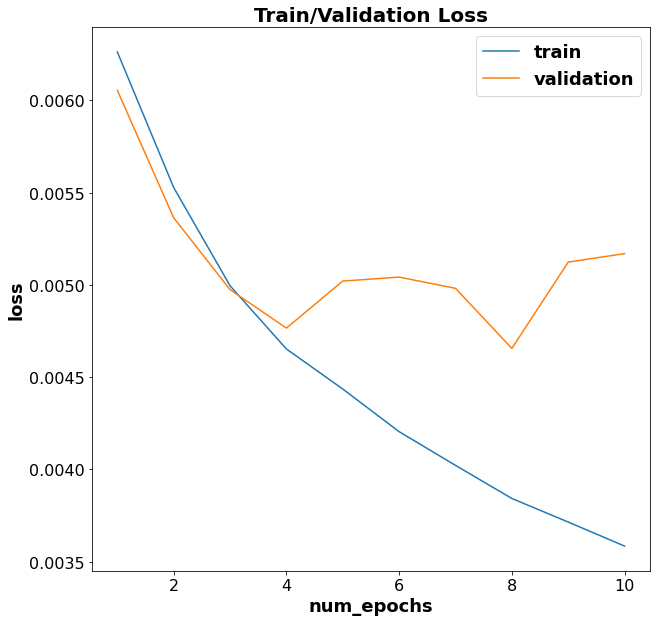

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_epoch_loss(nEpoch+4, train_loss_lst, val_loss_lst)

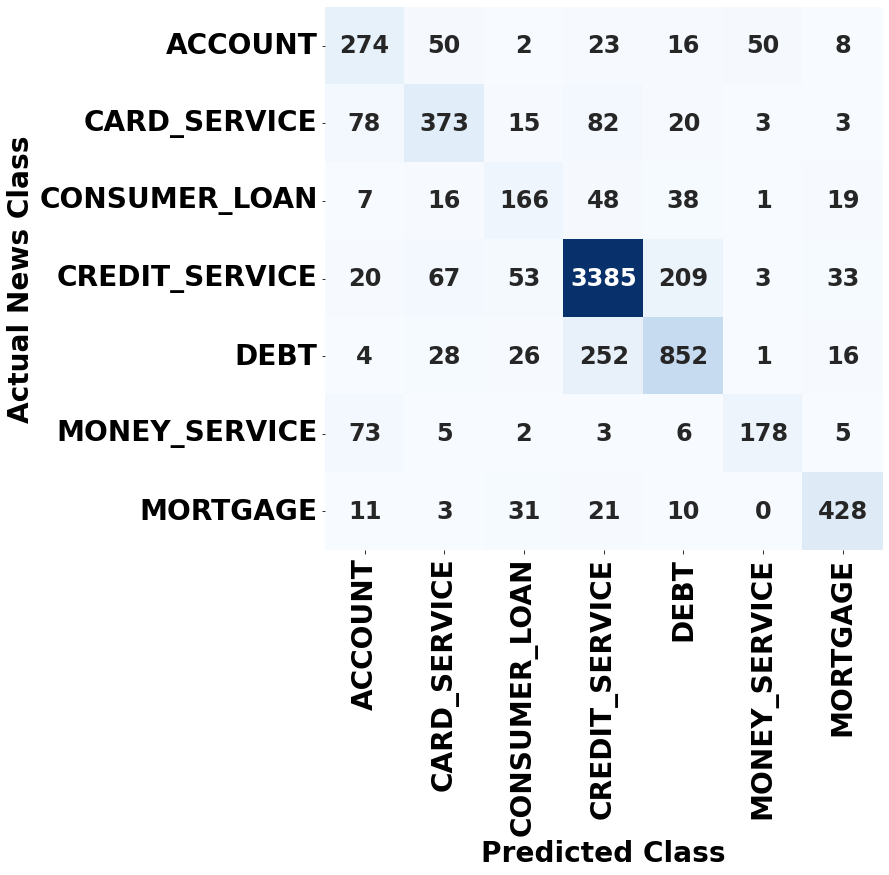

The F1 score of validation set is 0.8056139776405193


<Figure size 432x288 with 0 Axes>

In [ ]:
ticklabels = pd.read_csv("encoding_label_dict_token.csv", names = ["name", "label"], header = 0)
ticklabels = ticklabels["name"].tolist()

plot_confusion_matrix(labels_test, val_preds, ticklabels)

## 50 Embedding 10 Epoch With Glove

In [ ]:
VOCAB_SIZE = max(word2i.values()) + 2
model = NSE(VOCAB_SIZE, embed_mat=weights_matrix, freeze_embed=True).cuda()
nEpoch = 10

In [ ]:
train_loss_lst = []
val_loss_lst = []
for epoch in range(nEpoch):
    (sentences_shuffled, labels_shuffled) = shuffle_sentences(sentences_train, labels_train)
    train_loss, train_acc = train_model(sentences_shuffled, labels_shuffled, model)
    # torch.cuda.empty_cache()
    val_loss, val_acc, val_preds = eval_model(sentences_test, labels_test, model)
    # torch.cuda.empty_cache()
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.4f}, Val. Loss: {val_loss:3f}, Val. Acc: {val_acc:.4f}')
    train_loss_lst.append(train_loss)
    val_loss_lst.append(val_loss)

  0%|          | 0/220 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 01, Train Loss: 0.010, Train Acc: 0.5424, Val. Loss: 0.009269, Val. Acc: 0.5651


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 02, Train Loss: 0.010, Train Acc: 0.5593, Val. Loss: 0.009290, Val. Acc: 0.5673


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 03, Train Loss: 0.009, Train Acc: 0.5721, Val. Loss: 0.008780, Val. Acc: 0.5786


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 04, Train Loss: 0.009, Train Acc: 0.5852, Val. Loss: 0.008572, Val. Acc: 0.6168


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 05, Train Loss: 0.008, Train Acc: 0.6161, Val. Loss: 0.007909, Val. Acc: 0.6273


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 06, Train Loss: 0.008, Train Acc: 0.6236, Val. Loss: 0.007769, Val. Acc: 0.6406


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 07, Train Loss: 0.008, Train Acc: 0.6295, Val. Loss: 0.007598, Val. Acc: 0.6463


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 08, Train Loss: 0.008, Train Acc: 0.6355, Val. Loss: 0.007428, Val. Acc: 0.6528


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 09, Train Loss: 0.008, Train Acc: 0.6429, Val. Loss: 0.007337, Val. Acc: 0.6613


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 10, Train Loss: 0.008, Train Acc: 0.6437, Val. Loss: 0.007251, Val. Acc: 0.6575


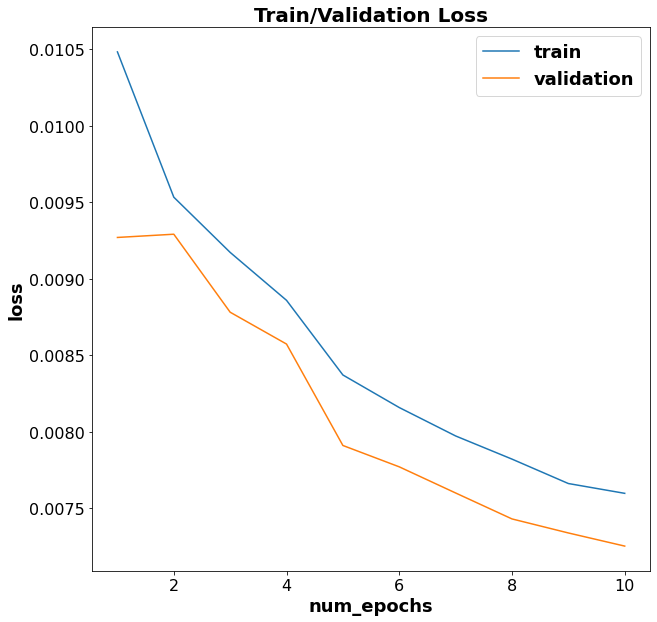

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_epoch_loss(nEpoch, train_loss_lst, val_loss_lst)

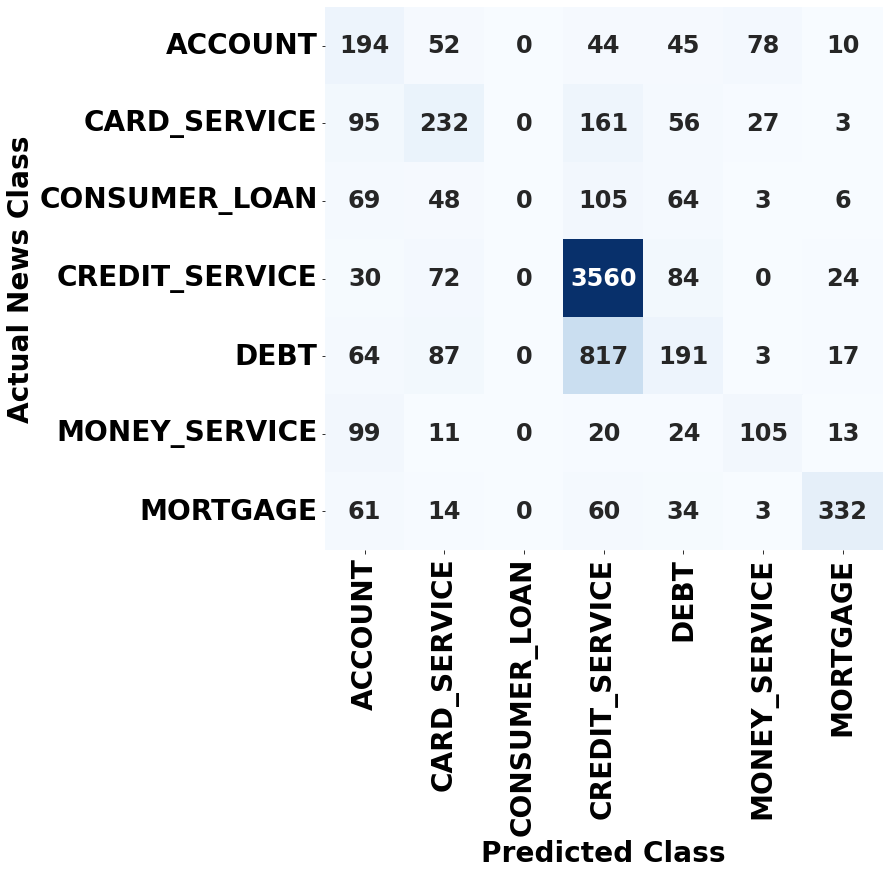

The F1 score of validation set is 0.612828234401766


<Figure size 432x288 with 0 Axes>

In [ ]:
ticklabels = pd.read_csv("encoding_label_dict_token.csv", names = ["name", "label"], header = 0)
ticklabels = ticklabels["name"].tolist()

plot_confusion_matrix(labels_test, val_preds, ticklabels)

## No dropout 10 epoch without Glove

In [ ]:
VOCAB_SIZE = max(word2i.values()) + 2
model = NSE(VOCAB_SIZE, dropout=0.0).cuda()
nEpoch = 10

In [ ]:
train_loss_lst = []
val_loss_lst = []
for epoch in range(nEpoch):
    (sentences_shuffled, labels_shuffled) = shuffle_sentences(sentences_train, labels_train)
    train_loss, train_acc = train_model(sentences_shuffled, labels_shuffled, model)
    # torch.cuda.empty_cache()
    val_loss, val_acc, val_preds = eval_model(sentences_test, labels_test, model)
    # torch.cuda.empty_cache()
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.4f}, Val. Loss: {val_loss:3f}, Val. Acc: {val_acc:.4f}')
    train_loss_lst.append(train_loss)
    val_loss_lst.append(val_loss)

  0%|          | 0/220 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 01, Train Loss: 0.008, Train Acc: 0.5979, Val. Loss: 0.007282, Val. Acc: 0.6501


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 02, Train Loss: 0.006, Train Acc: 0.7044, Val. Loss: 0.006021, Val. Acc: 0.7190


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 03, Train Loss: 0.005, Train Acc: 0.7661, Val. Loss: 0.005179, Val. Acc: 0.7681


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 04, Train Loss: 0.005, Train Acc: 0.7960, Val. Loss: 0.004965, Val. Acc: 0.7814


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 05, Train Loss: 0.004, Train Acc: 0.8104, Val. Loss: 0.005058, Val. Acc: 0.7859


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 06, Train Loss: 0.004, Train Acc: 0.8194, Val. Loss: 0.004971, Val. Acc: 0.7882


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 07, Train Loss: 0.004, Train Acc: 0.8250, Val. Loss: 0.004819, Val. Acc: 0.7926


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 08, Train Loss: 0.004, Train Acc: 0.8308, Val. Loss: 0.004832, Val. Acc: 0.7934


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 09, Train Loss: 0.004, Train Acc: 0.8385, Val. Loss: 0.004889, Val. Acc: 0.7931


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 10, Train Loss: 0.004, Train Acc: 0.8401, Val. Loss: 0.004702, Val. Acc: 0.7942


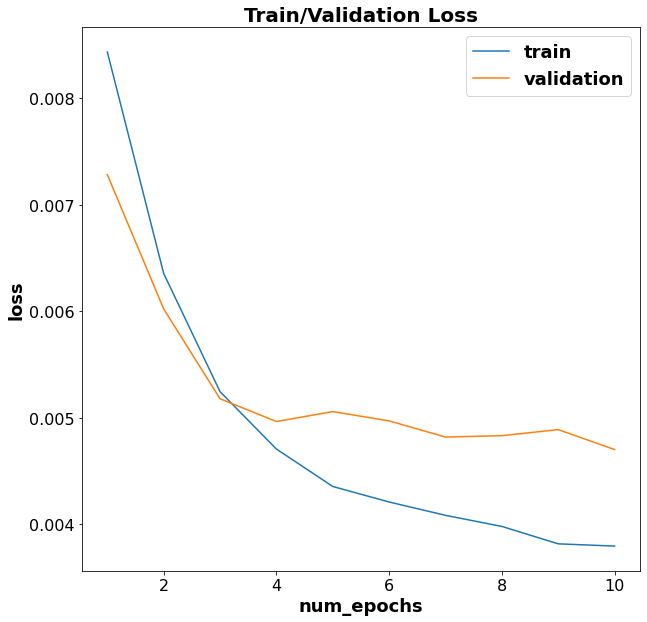

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_epoch_loss(nEpoch, train_loss_lst, val_loss_lst)

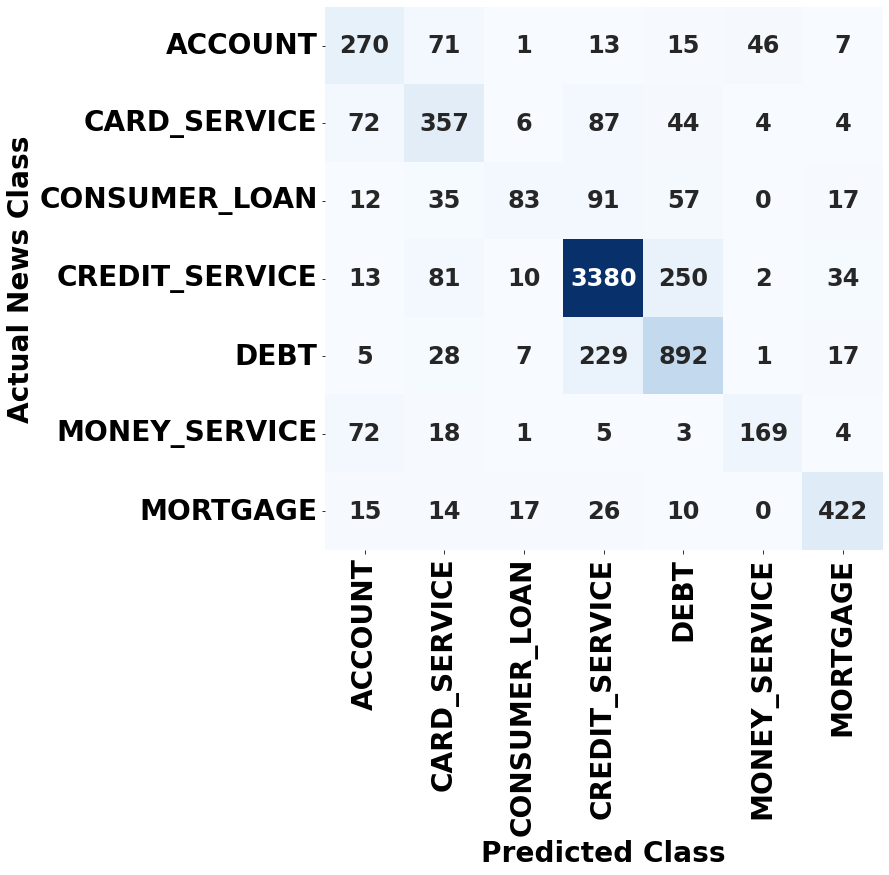

The F1 score of validation set is 0.7898744888063325


<Figure size 432x288 with 0 Axes>

In [ ]:
ticklabels = pd.read_csv("encoding_label_dict_token.csv", names = ["name", "label"], header = 0)
ticklabels = ticklabels["name"].tolist()

plot_confusion_matrix(labels_test, val_preds, ticklabels)

## Learning Rate 0.0001

In [ ]:
VOCAB_SIZE = max(word2i.values()) + 2
model = NSE(VOCAB_SIZE).cuda()
nEpoch = 10

In [ ]:
train_loss_lst = []
val_loss_lst = []
for epoch in range(nEpoch):
    (sentences_shuffled, labels_shuffled) = shuffle_sentences(sentences_train, labels_train)
    train_loss, train_acc = train_model(sentences_shuffled, labels_shuffled, model)
    # torch.cuda.empty_cache()
    val_loss, val_acc, val_preds = eval_model(sentences_test, labels_test, model)
    # torch.cuda.empty_cache()
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.4f}, Val. Loss: {val_loss:3f}, Val. Acc: {val_acc:.4f}')
    train_loss_lst.append(train_loss)
    val_loss_lst.append(val_loss)

  0%|          | 0/220 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 01, Train Loss: 0.013, Train Acc: 0.5274, Val. Loss: 0.010941, Val. Acc: 0.5373


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 02, Train Loss: 0.011, Train Acc: 0.5320, Val. Loss: 0.009664, Val. Acc: 0.5373


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 03, Train Loss: 0.010, Train Acc: 0.5363, Val. Loss: 0.009283, Val. Acc: 0.5394


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 04, Train Loss: 0.009, Train Acc: 0.5486, Val. Loss: 0.008992, Val. Acc: 0.5643


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 05, Train Loss: 0.009, Train Acc: 0.5622, Val. Loss: 0.008782, Val. Acc: 0.5817


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 06, Train Loss: 0.009, Train Acc: 0.5711, Val. Loss: 0.008692, Val. Acc: 0.5836


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 07, Train Loss: 0.009, Train Acc: 0.5740, Val. Loss: 0.008503, Val. Acc: 0.5813


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 08, Train Loss: 0.009, Train Acc: 0.5765, Val. Loss: 0.008345, Val. Acc: 0.5850


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 09, Train Loss: 0.009, Train Acc: 0.5775, Val. Loss: 0.008215, Val. Acc: 0.5846


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 10, Train Loss: 0.008, Train Acc: 0.5833, Val. Loss: 0.008129, Val. Acc: 0.5870


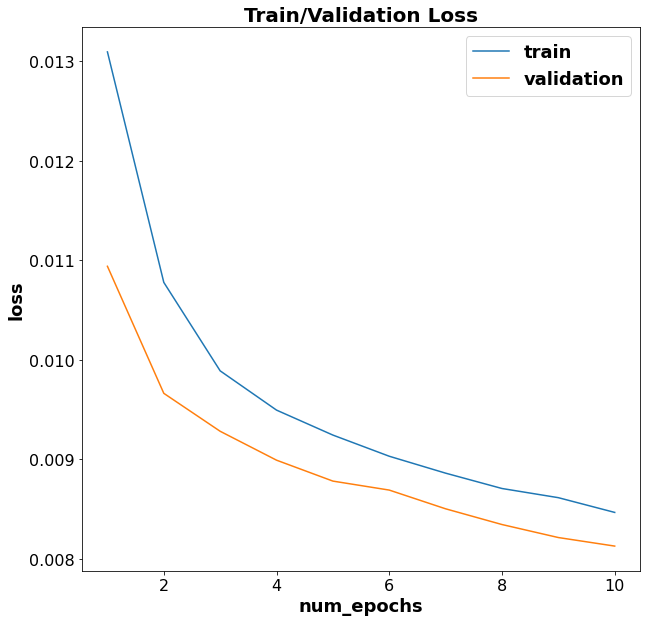

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_epoch_loss(nEpoch, train_loss_lst, val_loss_lst)

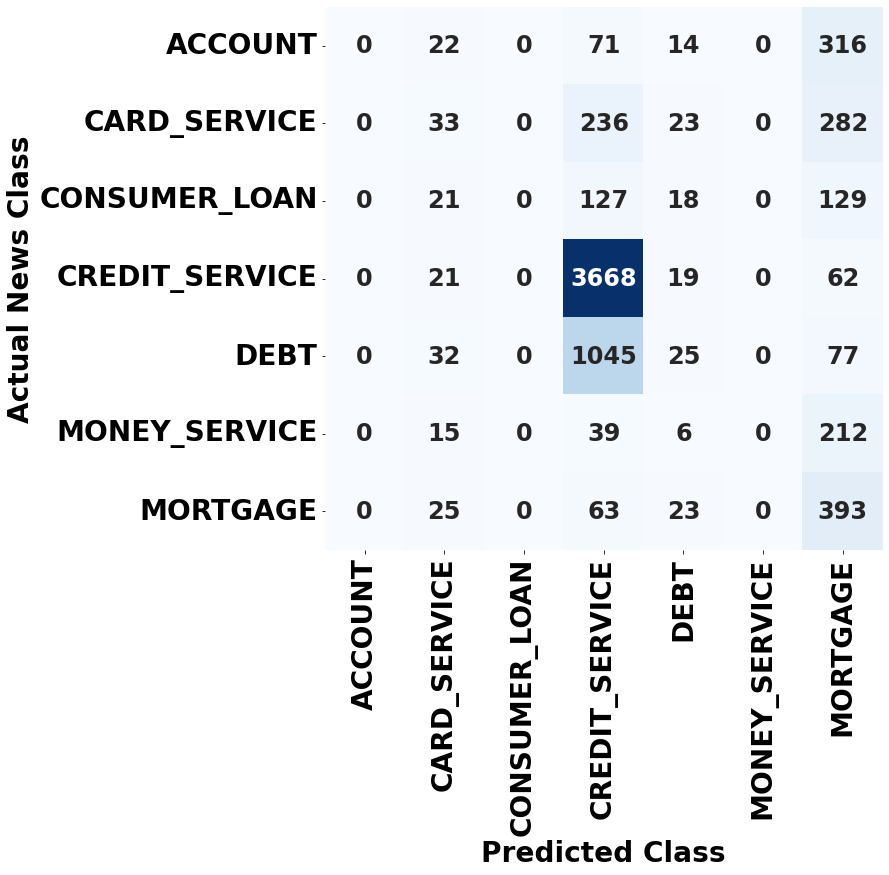

The F1 score of validation set is 0.47928824202323905


<Figure size 432x288 with 0 Axes>

In [ ]:
ticklabels = pd.read_csv("encoding_label_dict_token.csv", names = ["name", "label"], header = 0)
ticklabels = ticklabels["name"].tolist()

plot_confusion_matrix(labels_test, val_preds, ticklabels)

## 5 epoch 50 emb dim without glove 0.5 dropout

In [ ]:
VOCAB_SIZE = max(word2i.values()) + 2
model = NSE(VOCAB_SIZE).cuda()
nEpoch = 5

In [ ]:
train_loss_lst = []
val_loss_lst = []
for epoch in range(nEpoch):
    (sentences_shuffled, labels_shuffled) = shuffle_sentences(sentences_train, labels_train)
    train_loss, train_acc = train_model(sentences_shuffled, labels_shuffled, model)
    # torch.cuda.empty_cache()
    val_loss, val_acc, val_preds = eval_model(sentences_test, labels_test, model)
    # torch.cuda.empty_cache()
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.4f}, Val. Loss: {val_loss:3f}, Val. Acc: {val_acc:.4f}')
    train_loss_lst.append(train_loss)
    val_loss_lst.append(val_loss)

  0%|          | 0/1097 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


  0%|          | 0/275 [00:00<?, ?it/s]

Epoch: 01, Train Loss: 0.008, Train Acc: 0.6308, Val. Loss: 0.006497, Val. Acc: 0.6881


  0%|          | 0/1097 [00:00<?, ?it/s]

  0%|          | 0/275 [00:00<?, ?it/s]

Epoch: 02, Train Loss: 0.007, Train Acc: 0.6784, Val. Loss: 0.006581, Val. Acc: 0.6875


  0%|          | 0/1097 [00:00<?, ?it/s]

  0%|          | 0/275 [00:00<?, ?it/s]

Epoch: 03, Train Loss: 0.007, Train Acc: 0.6860, Val. Loss: 0.006219, Val. Acc: 0.7109


  0%|          | 0/1097 [00:00<?, ?it/s]

  0%|          | 0/275 [00:00<?, ?it/s]

Epoch: 04, Train Loss: 0.007, Train Acc: 0.6933, Val. Loss: 0.006166, Val. Acc: 0.7116


  0%|          | 0/1097 [00:00<?, ?it/s]

  0%|          | 0/275 [00:00<?, ?it/s]

Epoch: 05, Train Loss: 0.007, Train Acc: 0.6963, Val. Loss: 0.006238, Val. Acc: 0.7128


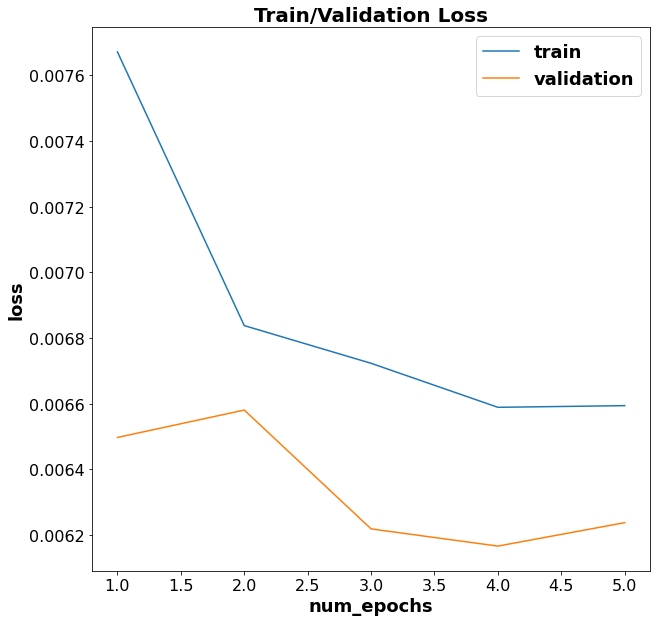

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_epoch_loss(nEpoch, train_loss_lst, val_loss_lst)

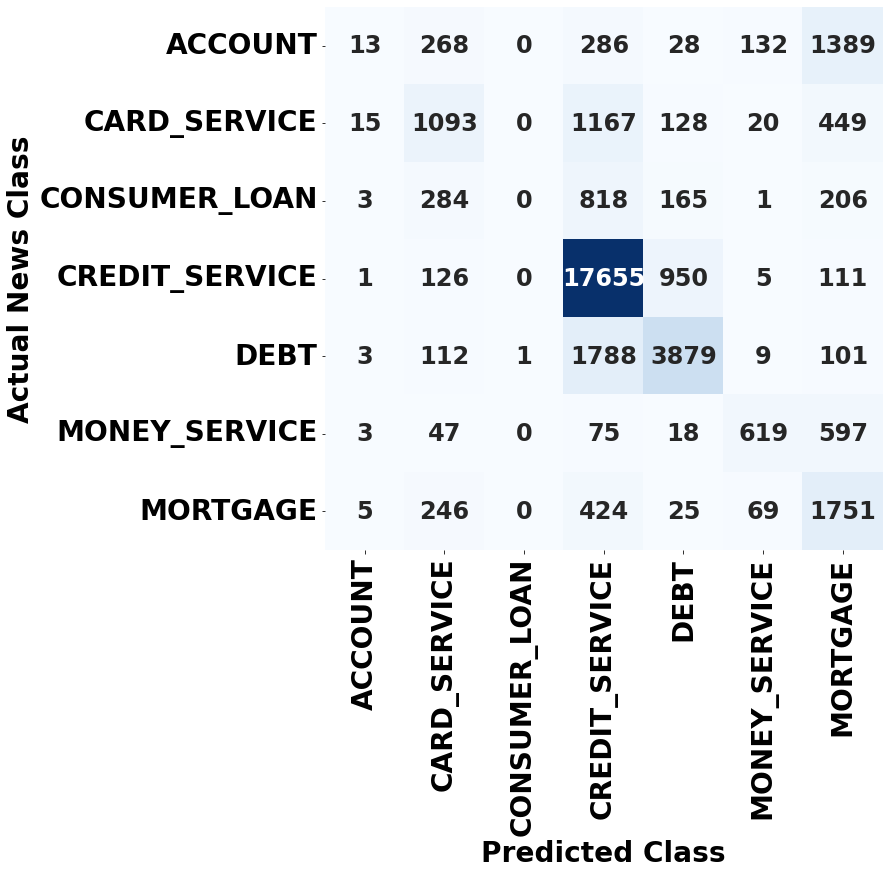

The F1 score of validation set is 0.6726506751899423


<Figure size 432x288 with 0 Axes>

In [ ]:
ticklabels = pd.read_csv("encoding_label_dict_token.csv", names = ["name", "label"], header = 0)
ticklabels = ticklabels["name"].tolist()

plot_confusion_matrix(labels_test, val_preds, ticklabels)